In [303]:
import json
import re
import string
import pymorphy2
import stop_words
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem.snowball import RussianStemmer
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
# модели
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

In [228]:
# настраиваемые параметры
article_filename = "articles.json" # путь до файла с полным сохранением статей
vectorized_filename = "vectorized_train.npy"
categories = ["entertainment", "auto", "sport", "health"]

In [8]:
news = []
with open(article_filename, encoding="utf-8") as file:
    for line in file:
        news.append(json.loads(line))
data = pd.DataFrame(news)
data.head()

,article_id,title,category,tags,text
0,https://www.nn.ru/text/entertainment/2023/01/1...,Кто такой цуцик и где раки зимуют? Попробуйте ...,entertainment,"Развлечения,Знания,История,Развлечения,Тест,Фр...","Если бы не было фразеологизмов, наша речь (а в..."
1,https://www.nn.ru/text/entertainment/2023/01/1...,Снова как мальчик: Филипп Киркоров резко помол...,entertainment,"Развлечения,Филипп Киркоров,Звезды,Шоу-бизнес","Редко кто может похвастаться тем, что после ка..."
2,https://www.nn.ru/text/entertainment/2023/01/1...,2023 — это колесница: каким будет год Черного ...,entertainment,"Развлечения,Гороскоп,Нумеролог,Прогноз нумерол...","Если присмотреться внимательнее, то можно обна..."
3,https://www.nn.ru/text/entertainment/2023/01/1...,Вам не решить: 10 советских задач в картинках ...,entertainment,"Развлечения,СССР,Интересный тест,Тест,Внимание...",Ставить опыты над возможностями человеческих п...
4,https://www.nn.ru/text/entertainment/2023/01/1...,Не только «Ёлки-9»: что больше всего приглянул...,entertainment,Развлечения,Wink представляет самые популярные фильмы и се...


In [138]:
data.shape

(4057, 5)

# 1. Предобработка собранного корпуса (датасет новостей): удаление знаков препинания и лишних символов, токенизация, приведение к нормальной форме, удаление стоп-слов.

### Преобразование текста

In [121]:
EXCLUDE_SYMBOLS_STR = u''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                                '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                                '\x7f', '\xad', '¤', '\xa0', '\u200e'])

In [127]:
corpus = [re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text) for text in data["text"]] # удаление ссылок
corpus = [text.lower() for text in corpus] # приведение к нижнему регистру
corpus = [re.sub(r'[\d\w-]{1,}\.(ru|com|ua)' , '', text) for text in corpus] # удаление неполных ссылок
# в статьях нет \n или \t

regex_punct = re.compile('[%s]' % re.escape(string.punctuation))
corpus = [regex_punct.sub('', text) for text in corpus] # убираем пунктуацию

regex_dig = re.compile('[%s]' % re.escape(string.digits))
corpus = [regex_dig.sub('', text) for text in corpus] # убираем цифры

regex_symb = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
corpus = [regex_symb.sub(' ', text) for text in corpus] # убираем дополнительные символы

corpus = [re.sub(' +' , ' ', text) for text in corpus] # оставляем максимум 1 пробел
corpus = [text.strip() for text in corpus] # удаляем лишние пробелы в начале и конце статей

### Токенизация и пропуск стоп-слов

In [132]:
morph = pymorphy2.MorphAnalyzer()

In [135]:
corpus_tokens = [] # для токенов из строк
inds_to_drop = [] # статьи, что будут убраны

for i, sentence in enumerate(corpus):
    tmp_tokens = [] # временный массив с токенами
    sp = sentence.split() # разделяем строку по пробелам
    for word in sp: # проходим по словам в строке
        if word not in stop_words.get_stop_words('ru'): # если слова нет в списке стоп-слов для русского языка
            if morph.word_is_known(word): # проверяет, что слово есть в словаре
                tmp_tokens.append(word) # добавляем токен
    if len(tmp_tokens) > 0: # если после попытки токенизации строки получилось хоть сколько-то токенов, то записываем их в corpus_tokens
        corpus_tokens.append(tmp_tokens)
    else: # иначе - добавляем строку в дропы
        inds_to_drop.append(i)
        
print(len(corpus_tokens), len(inds_to_drop)) # в данном случае, все статьи были токенизированы

4057 0


### Приведение к нормальной форме

In [153]:
stemmer = RussianStemmer() # стеммер для нахождения основы слова

In [182]:
corpus_tokens_stem = []

for i, tokens in enumerate(corpus_tokens):
    tmp = [stemmer.stem(word) for word in tokens] # проходимся стеммером по всем токенам для получения основы слова-токена
    corpus_tokens_stem.append(tmp)
corpus_tokens_stem = np.asarray(corpus_tokens_stem)

C:\Users\User\Documents\TEMP\ipykernel_50604\1241036772.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  corpus_tokens_stem = np.asarray(corpus_tokens_stem)


Частота встречи различного числа основ (токенов)

In [183]:
diffs = np.asarray([len(tokens) for tokens in corpus_tokens_stem]) # массив числа основ токенов, оставшихся в статьях
print(diffs.min()) # минимум основ (нормализованных токенов) = 10

10


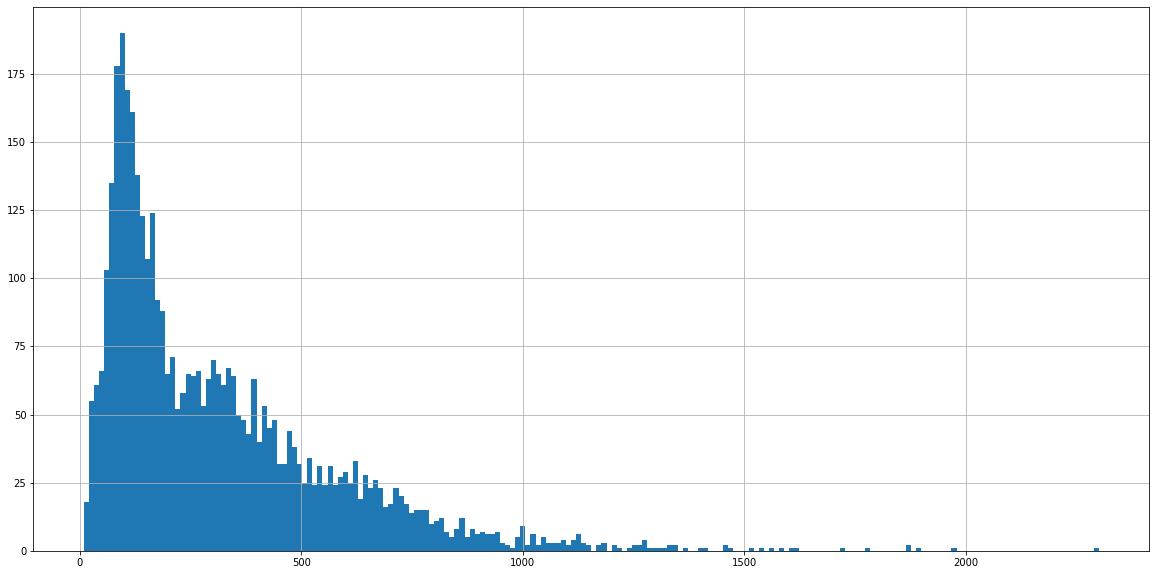

In [184]:
plt.figure(figsize=(20, 10))
plt.hist(diffs, bins=200)
plt.grid(True)

Число встреченных основ (словарь)

In [190]:
vocab = np.unique(np.concatenate(corpus_tokens_stem).flatten()).tolist()
print(len(vocab))

37108


Сбор датасета

In [420]:
dataset = []
for i in range(len(corpus_tokens_stem)):
    dataset.append([' '.join(corpus_tokens_stem[i]), data["category"][i]])
dataset = pd.DataFrame(dataset, columns=["text", "category"])

In [390]:
dataset

,text,category
0,фразеологизм реч возможн скучн интересн пользо...,entertainment
1,редк похваста каникул набра лишн килограмм зар...,entertainment
2,присмотрет внимательн обнаруж повсюд окружа ци...,entertainment
3,став опыт возможн человеческ познан придума по...,entertainment
4,представля сам популярн фильм сериал смотрел н...,entertainment
...,...,...
4052,перв новост появ полутор мир охват пандем мног...,health
4053,официальн представител кремл дмитр песк проком...,health
4054,успел росс отойт трет волн коронавирус пришл ч...,health
4055,летн екатеринбуржец евген реш подел истор проч...,health


# 2. Векторизация текста

Разбиение на тренировочную/тестовую выборку

In [424]:
data_train, data_test = train_test_split(dataset, test_size=0.1)
print(len(data_train), len(data_test))

3651 406


In [425]:
data_train.category.value_counts()

auto             923
sport            921
health           915
entertainment    892
Name: category, dtype: int64

In [391]:
vectorizer = TfidfVectorizer(vocabulary=vocab)
vectorizer.fit(dataset)

TfidfVectorizer(vocabulary=['а', 'аа', 'аарон', 'аб', 'абабковск', 'абажур',
                            'абаз', 'абаим', 'абака', 'абакан', 'абакум',
                            'абакумов', 'абандон', 'абашкин', 'аббатств',
                            'аббревиатур', 'абд', 'абдалл', 'абдельазиз',
                            'абдом', 'абдоминальн', 'абдрахманов', 'абдряхим',
                            'абдул', 'абдула', 'абдулаев', 'абдулкерим',
                            'абдулл', 'абдулмажид', 'абдулмеджид', ...])

In [431]:
data_train_vect = vectorizer.transform(data_train["text"])
data_train_cat = data_train["category"]
data_test_vect = vectorizer.transform(data_test["text"])
data_test_cat = data_test["category"]

# 3. Классификация категорий собственного новостного корпуса с помощью моделей классического машинного обучения.

Использование моделей для предсказания:

1) модель KNN (K-Nearest Neighbors — K Ближайших Соседей)

In [448]:
parameters_knn = { # параметры для KNN модели
    "n_neighbors": [3, 5, 10, 15],
    "weights": ["uniform", "distance"],
    "metric": ["minkowski", "manhattan"]
}

gs_knn = GridSearchCV( # параметры GridSearchCV
    KNeighborsClassifier(),
    parameters_knn,
    verbose = 1,
    cv=5,
    n_jobs=-1
)

gs_knn_res = gs_knn.fit(data_train_vect, data_train_cat) # подбираем лучшие параметры для оценщика
pred_knn = gs_knn_res.best_estimator_.predict(data_test_vect) # предсказываем
print(metrics.classification_report(data_test_cat, pred_knn)) # выписываем основные метрики

Fitting 5 folds for each of 16 candidates, totalling 80 fits
               precision    recall  f1-score   support

         auto       0.94      0.96      0.95        95
entertainment       0.95      0.81      0.88       108
       health       0.92      0.97      0.94       106
        sport       0.90      0.97      0.94        97

     accuracy                           0.93       406
    macro avg       0.93      0.93      0.93       406
 weighted avg       0.93      0.93      0.92       406



2) модель SGD (Stochastic Gradient Descent — Стохастический Градиентный Спуск)

In [450]:
parameters_sgd = {
    "penalty": ["elasticnet", "l2", "l1"],
    "alpha": [0.0001, 0.01, 0.1, 0.5, 1, 5],
    "max_iter": [100, 500, 1000, 2000],
    "learning_rate": ["optimal", "invscaling", "adaptive"],
    "eta0": [1, 10]
}

gs_sgd = GridSearchCV(
    SGDClassifier(),
    parameters_sgd,
    verbose = 1,
    cv=5,
    n_jobs=-1
)

gs_sgd_res = gs_sgd.fit(data_train_vect, data_train_cat)
pred_sgd = gs_sgd_res.best_estimator_.predict(data_test_vect)
print(metrics.classification_report(data_test_cat, pred_sgd))

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
               precision    recall  f1-score   support

         auto       1.00      0.97      0.98        95
entertainment       0.96      0.94      0.95       108
       health       0.96      0.97      0.97       106
        sport       0.95      0.99      0.97        97

     accuracy                           0.97       406
    macro avg       0.97      0.97      0.97       406
 weighted avg       0.97      0.97      0.97       406



4. Анализ полученных результатов. Сравнение метрики качества, визуализация, выводы.

In [444]:
gs_knn_res.best_params_

{'metric': 'minkowski', 'n_neighbors': 3, 'weights': 'distance'}

In [446]:
gs_knn_res.best_score_

0.9405614377002793

In [ ]:
+ матрица самых важных слов для классификаторов